In [294]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import spacy

nltk.download('punkt') 
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nlp = spacy.load("en_core_web_sm")

from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

stop_words = set(stopwords.words('english'))
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from collections import Counter

[nltk_data] Downloading package punkt to /Users/leon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/leon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/leon/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/leon/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /Users/leon/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [295]:
files = ['Data/Customer_review_data/Apex AD2600 Progressive-scan DVD player.txt',
         'Data/Customer_review_data/Canon G3.txt',
         'Data/Customer_review_data/Creative Labs Nomad Jukebox Zen Xtra 40GB.txt',
         'Data/Customer_review_data/Nikon coolpix 4300.txt',
         'Data/Customer_review_data/Nokia 6610.txt',
         'Data/CustomerReviews-3_domains/Computer.txt',
         'Data/CustomerReviews-3_domains/Router.txt',
         'Data/CustomerReviews-3_domains/Speaker.txt',
         'Data/Reviews-9-products/Canon PowerShot SD500.txt',
         'Data/Reviews-9-products/Canon S100.txt',
         'Data/Reviews-9-products/Diaper Champ.txt',
         'Data/Reviews-9-products/Hitachi router.txt',
         'Data/Reviews-9-products/ipod.txt',
         'Data/Reviews-9-products/Linksys Router.txt',
         'Data/Reviews-9-products/MicroMP3.txt',
         'Data/Reviews-9-products/Nokia 6600.txt',
         'Data/Reviews-9-products/norton.txt']

In [296]:
def read_file(file_path):
    tagged_reviews = []
    
    with open(file_path, 'r') as file:
        text = file.read()
        reviews = text.strip().split('\n')

        if reviews[0] == '*****************************************************************************':
            reviews = reviews[11:]
        
        for review in reviews:
            parts = review.split('##')
            
            if len(parts) > 1:
                tags = parts[0].strip().split(',')
                content = parts[1].strip() 
            else:
                tags = []
                content = parts
                
            tagged_reviews.append({'Tags': tags, 'Review': content})

        df = pd.DataFrame(tagged_reviews)
        df.attrs['title'] = file_path.split('/')[-1]

        return df
            

df = read_file(files[0])

In [307]:
df['Tokenised_Review'] = df['Review'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x) 
df['Tokenised_Review'] = df['Tokenised_Review'].apply(lambda review: word_tokenize(review))
df['Tokenised_Review_String'] = df['Tokenised_Review'].apply(lambda tokens: ' '.join(tokens))
df['Filtered_Review'] = df['Tokenised_Review'].apply(lambda tokens: [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words])
df['Filtered_Review_String'] = df['Filtered_Review'].apply(lambda tokens: ' '.join(tokens))
df['Lemmatized_Review_String'] = df['Filtered_Review_String'].apply(lambda review_string: " ".join([token.lemma_ for token in nlp(review_string)]))

In [308]:
all_words = [word for review in df['Filtered_Review'] for word in review]
freq_dist = FreqDist(all_words)

def display_freq_dist(freq_dist):
    top_items = sorted(freq_dist.items(), key=lambda x: x[1], reverse=True)[:20]
    words, frequencies = zip(*top_items)
    plt.figure(figsize=(6, 3))  
    plt.bar(words, frequencies, color='skyblue')  
    plt.xlabel('Words') 
    plt.ylabel('Frequency') 
    plt.title('Top Words Frequency Distribution')  
    plt.xticks(rotation=45) 
    plt.show()

# display_freq_dist(freq_dist)

Cluster 0: ['apex', 'get', 'problem', 'one', 'try', 'good', 'picture', 'use', 'remote', 'unit']
Cluster 1: ['player', 'dvd', 'buy', 'apex', 'christmas', 'purchase', 'one', 'price', 'gift', 'good']
Cluster 2: ['play', 'dvd', 'dvds', 'movie', 'everything', 'player', 'disc', 'would', 'problem', 'without']
Cluster 3: ['work', 'great', 'player', 'fine', 'one', 'feature', 'apex', 'price', 'seem', 'dvd']
Cluster 4: ['money', 'value', 'worth', 'well', 'save', 'apex', 'spend', 'good', 'get', 'buy']




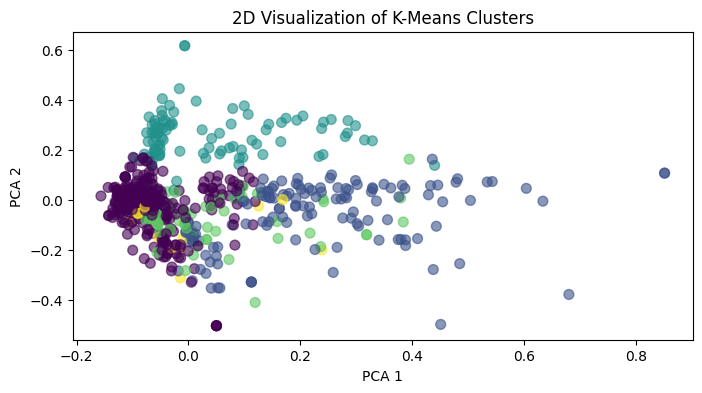

In [311]:
def k_means(string_list):

    tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), max_df=0.85, min_df=2)
    tfidf_matrix = tfidf_vectorizer.fit_transform(string_list)
    
    km = KMeans(n_clusters=5, n_init=10)
    km.fit(tfidf_matrix)
    clusters = km.labels_.tolist()
    
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    terms = tfidf_vectorizer.get_feature_names_out()
    
    for i in range(num_clusters):
        top_terms = [terms[ind] for ind in order_centroids[i, :10]]  # Get top 10 terms for each cluster
        print(f"Cluster {i}: {top_terms}")
    
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(tfidf_matrix.toarray())
    
    # Get the cluster labels for each data point
    cluster_labels = km.labels_
    
    plt.figure(figsize=(8, 4))  # Set figure size
    
    # Scatter plot of the reduced data, colored by cluster labels
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='viridis', s=50, alpha=0.6)
    
    # Adding labels for axes
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    
    # Title of the plot
    plt.title('2D Visualization of K-Means Clusters')
    
    # Display the plot
    print('\n')
    plt.show()


k_means(df['Lemmatized_Review_String'])

In [310]:
def POS_Noun_Tagging(string_list):
    
    reviews = string_list.tolist()
    features = []
    
    for review in reviews:
        tokens = word_tokenize(review)
        tagged = pos_tag(tokens)
        # Extracts nouns from POS tagged text as nouns likely features names
        features.extend([word.lower() for word, tag in tagged if tag in ['NN', 'NNS', 'NNP', 'NNPS']])
    
    feature_counts = Counter(features)
    common_features = feature_counts.most_common(15)
    print(common_features)

POS_Noun_Tagging(df['Filtered_Review_String'])

[('player', 144), ('dvd', 123), ('apex', 51), ('play', 35), ('picture', 30), ('problems', 30), ('price', 30), ('dvds', 30), ('unit', 29), ('problem', 26), ('service', 24), ('money', 22), ('customer', 22), ('christmas', 21), ('features', 21)]


In [290]:
def Noun_Phrase_Chuncking(string_list):

    all_noun_phrases = []
    
    for review in string_list:
        doc = nlp(review)
        noun_phrases = [chunk.text.lower() for chunk in doc.noun_chunks]
        all_noun_phrases.extend(noun_phrases)
    
    # Count the occurrences of each noun phrase
    from collections import Counter
    phrase_counts = Counter(all_noun_phrases)
    
    # Display most common noun phrases
    common_phrases = phrase_counts.most_common(15)
    print(common_phrases)
    

Noun_Phrase_Chuncking(df['Filtered_Review_String'])

[('dvd player', 19), ('player', 18), ('apex', 16), ('problems', 15), ('dvd', 14), ('everything', 12), ('money', 11), ('dvds', 10), ('amazon', 9), ('something', 8), ('problem', 8), ('unit', 8), ('picture', 7), ('button', 6), ('price', 6)]
